# Analysis after Peak-calling with MACS2

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
def readBroadPeak(file, qthreshold=0.01, lenthreshold=250):
    data = pd.read_csv(file, sep='\t', header=None, 
            names = ['Chrom', 'start', 'end', 'name', 'score', '.', 'fc', 'neglogp', 'neglogq'])
    data['len'] = abs(data['start'] - data['end'])
    export_data = data[(data.neglogq >= (-1)*np.log10(qthreshold)) & (data.len >= lenthreshold)]
    export_data = export_data.drop(columns=['len'])
    return export_data

In [88]:
IRI1A = readBroadPeak('./IRI1A_peaks.broadPeak')
IRI2A = readBroadPeak('./IRI2A_peaks.broadPeak')
SHAM1A = readBroadPeak('./Sham1A_peaks.broadPeak')
SHAM2A =  readBroadPeak('./Sham2A_peaks.broadPeak')

In [89]:
IRI1A.to_csv("./IRI1A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
IRI2A.to_csv("./IRI2A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
SHAM1A.to_csv("./SHAM1A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
SHAM2A.to_csv("./SHAM2A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)

In [90]:
IRI1A.describe()

,start,end,score,fc,neglogp,neglogq
count,8.290200e+04,8.290200e+04,82902.000000,82902.000000,82902.000000,82902.000000
mean,7.474784e+07,7.474873e+07,165.733300,4.345791,18.603464,16.623200
std,4.395640e+07,4.395640e+07,225.955258,1.736312,22.839966,22.595563
min,8.085650e+05,8.102000e+05,20.000000,1.586580,3.482290,2.000030
25%,3.688139e+07,3.688208e+07,39.000000,3.028540,5.757837,3.972822
50%,7.251729e+07,7.251784e+07,80.000000,3.824855,9.972725,8.065150
75%,1.075940e+08,1.075951e+08,191.000000,5.201398,21.297007,19.195873
max,1.952320e+08,1.952331e+08,2950.000000,17.592900,298.922850,295.039490


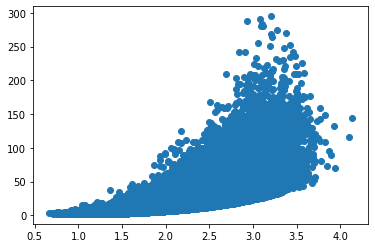

In [91]:
plt.scatter(np.log2(IRI1A.fc), IRI1A.neglogq)

In [1]:
import rpy2.ipython
%reload_ext rpy2.ipython

# suppress excessive warnings such as RRuntimeWarning
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

/auto/rcf-proj3/klj/kim130/miniconda3/envs/jupyter-R3.6/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Calling consensus peaks in Bioconductor

- Ref : https://ro-che.info/articles/2018-07-11-chip-seq-consensus

In [6]:
%%R
#library(UpSetR)
library(rtracklayer)
library(GenomicRanges)

## Getting total union peak set [No filter]

In [65]:
%%R
macs2_peak_files_unfiltered.files <- list.files(pattern =".*\\peaks.broadPeak")
macs2_peak_files_unfiltered.files

[1] "IRI1A_peaks.broadPeak"  "IRI2A_peaks.broadPeak"  "Sham1A_peaks.broadPeak"
[4] "Sham2A_peaks.broadPeak"


In [66]:
%%R
macs2_peak_files_unfiltered.granges <- lapply(macs2_peak_files_unfiltered.files, import)
macs2_peak_files_unfiltered.granges

[[1]]
GRanges object with 240761 ranges and 5 metadata columns:
           seqnames            ranges strand |              name     score
              <Rle>         <IRanges>  <Rle> |       <character> <numeric>
       [1]     chr1   3012435-3012743      * |      IRI1A_peak_1         0
       [2]     chr1   3014527-3015640      * |      IRI1A_peak_2         0
       [3]     chr1   3019513-3019738      * |      IRI1A_peak_3         0
       [4]     chr1   3026870-3027493      * |      IRI1A_peak_4         0
       [5]     chr1   3039077-3039284      * |      IRI1A_peak_5         3
       ...      ...               ...    ... .               ...       ...
  [240757]     chrY   9881596-9881797      * | IRI1A_peak_240757         0
  [240758]     chrY 10043114-10043337      * | IRI1A_peak_240758         0
  [240759]     chrY 10512796-10513008      * | IRI1A_peak_240759         1
  [240760]     chrY 41123356-41123789      * | IRI1A_peak_240760         0
  [240761]     chrY 41153398-4115357

In [67]:
%%R
macs2_peak_files_unfiltered.grangeslist <- GRangesList(macs2_peak_files_unfiltered.granges)
macs2_peak_files_unfiltered.grangeslist

GRangesList object of length 4:
[[1]] 
GRanges object with 240761 ranges and 5 metadata columns:
           seqnames            ranges strand |              name     score
              <Rle>         <IRanges>  <Rle> |       <character> <numeric>
       [1]     chr1   3012435-3012743      * |      IRI1A_peak_1         0
       [2]     chr1   3014527-3015640      * |      IRI1A_peak_2         0
       [3]     chr1   3019513-3019738      * |      IRI1A_peak_3         0
       [4]     chr1   3026870-3027493      * |      IRI1A_peak_4         0
       [5]     chr1   3039077-3039284      * |      IRI1A_peak_5         3
       ...      ...               ...    ... .               ...       ...
  [240757]     chrY   9881596-9881797      * | IRI1A_peak_240757         0
  [240758]     chrY 10043114-10043337      * | IRI1A_peak_240758         0
  [240759]     chrY 10512796-10513008      * | IRI1A_peak_240759         1
  [240760]     chrY 41123356-41123789      * | IRI1A_peak_240760         0
  [

In [68]:
%%R
macs2_peak_files_unfiltered.coverage <- coverage(macs2_peak_files_unfiltered.grangeslist)
macs2_peak_files_unfiltered.coverage

RleList of length 21
$chr1
integer-Rle of length 195309171 with 149926 runs
  Lengths: 3003426     444    8564      63 ...      20     187      83      10
  Values :       0       1       0       1 ...       1       3       2       1

$chr10
integer-Rle of length 130542265 with 96465 runs
  Lengths: 3170106     190    2598     164 ...     605       1      34       4
  Values :       0       1       0       1 ...       4       3       2       1

$chr11
integer-Rle of length 121977616 with 82210 runs
  Lengths: 3201954     115       7       1 ...    9015     290   11267     190
  Values :       0       1       2       3 ...       0       1       0       1

$chr12
integer-Rle of length 120002754 with 84471 runs
  Lengths: 3098110      26       3      15 ...     271     184    9280     193
  Values :       0       1       2       3 ...       2       1       0       1

$chr13
integer-Rle of length 120313820 with 80142 runs
  Lengths: 3045440     177     212      12 ...    1917     261    87

In [77]:
%%R
# slice function : https://support.bioconductor.org/p/83326/
# https://www.rdocumentation.org/packages/IRanges/versions/2.6.1/topics/slice-methods
# lower : the regions in the genome where coverage is at least 2
macs2_peak_files_unfiltered.covered_ranges <- slice(macs2_peak_files_unfiltered.coverage, lower=1, rangesOnly=T)
macs2_peak_files_unfiltered.covered_ranges <- GRanges(macs2_peak_files_unfiltered.covered_ranges)
macs2_peak_files_unfiltered.covered_ranges

GRanges object with 374668 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3003427-3003870      *
       [2]     chr1   3012435-3012785      *
       [3]     chr1   3014527-3015640      *
       [4]     chr1   3019513-3019738      *
       [5]     chr1   3026870-3027493      *
       ...      ...               ...    ...
  [374664]     chrY 10561059-10561294      *
  [374665]     chrY 41089491-41089671      *
  [374666]     chrY 41122766-41123933      *
  [374667]     chrY 41153012-41153221      *
  [374668]     chrY 41153398-41153576      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


#### Total Union peak : 374,668 peaks

In [79]:
%%R
# reduce function: reduce returns an object of the same type as x containing reduced ranges for each distinct
# (seqname, strand) pairing. The names (names(x)) and the metadata columns in x are dropped.
# See ?reduce for more information about range reduction and for a description of the optional arguments.
# More : https://www.rdocumentation.org/packages/GenomicRanges/versions/1.24.1/topics/inter-range-methods
macs2_peak_files_unfiltered.merged_covered_ranges <- reduce(macs2_peak_files_unfiltered.covered_ranges, 
                                                            min.gapwidth=500)

macs2_peak_files_unfiltered.merged_covered_ranges

GRanges object with 357013 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3003427-3003870      *
       [2]     chr1   3012435-3012785      *
       [3]     chr1   3014527-3015640      *
       [4]     chr1   3019513-3019738      *
       [5]     chr1   3026870-3028381      *
       ...      ...               ...    ...
  [357009]     chrY 10512787-10513033      *
  [357010]     chrY 10561059-10561294      *
  [357011]     chrY 41089491-41089671      *
  [357012]     chrY 41122766-41123933      *
  [357013]     chrY 41153012-41153576      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


#### Merged Union peaks (nearby threshold 500bp) : 357,013

In [80]:
%%R
export(macs2_peak_files_unfiltered.merged_covered_ranges, "post_macs2_peak-calling_consensus.noFilter.UNION.broadPeak.bed")

## Getting total union peak set [Filter FDR <= 0.01, len >= 250]

In [93]:
%%R
macs2_peak_files_filtered.files <- list.files(pattern =".*\\q.01.len250.broadPeak")
macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, import)
macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)
macs2_peak_files_filtered.coverage <- coverage(macs2_peak_files_filtered.grangeslist)
macs2_peak_files_filtered.covered_ranges <- slice(macs2_peak_files_filtered.coverage, lower=1, rangesOnly=T)
macs2_peak_files_filtered.covered_ranges <- GRanges(macs2_peak_files_filtered.covered_ranges)
macs2_peak_files_filtered.covered_ranges

GRanges object with 107460 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
       [1]     chr1 3116593-3117640      *
       [2]     chr1 3119338-3121591      *
       [3]     chr1 3126063-3126476      *
       [4]     chr1 3154842-3157891      *
       [5]     chr1 3176551-3176879      *
       ...      ...             ...    ...
  [107456]     chrY 1254838-1255276      *
  [107457]     chrY 2308813-2309456      *
  [107458]     chrY 5670911-5671236      *
  [107459]     chrY 5920093-5920381      *
  [107460]     chrY 9389661-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


In [122]:
%%R
print(mcols(macs2_peak_files_filtered.covered_ranges))

DataFrame with 107460 rows and 0 columns


#### Total Union peak : 107,460 peaks

In [94]:
%%R
macs2_peak_files_filtered.merged_covered_ranges <- reduce(macs2_peak_files_filtered.covered_ranges, 
                                                            min.gapwidth=500)
macs2_peak_files_filtered.merged_covered_ranges

GRanges object with 107371 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
       [1]     chr1 3116593-3117640      *
       [2]     chr1 3119338-3121591      *
       [3]     chr1 3126063-3126476      *
       [4]     chr1 3154842-3157891      *
       [5]     chr1 3176551-3176879      *
       ...      ...             ...    ...
  [107367]     chrY 1254838-1255276      *
  [107368]     chrY 2308813-2309456      *
  [107369]     chrY 5670911-5671236      *
  [107370]     chrY 5920093-5920381      *
  [107371]     chrY 9389661-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


In [123]:
%%R
print(mcols(macs2_peak_files_filtered.merged_covered_ranges))

DataFrame with 107371 rows and 0 columns


#### Merged Union peaks (nearby threshold 500bp) : 107,371

In [95]:
%%R
export(macs2_peak_files_filtered.merged_covered_ranges,
       "post_macs2_peak-calling_consensus.q.01.len250.UNION.broadPeak.bed")

### Individual files

In [127]:
%%R
merge_covered_range <- function(pattern=".*\\q.01.len250.broadPeak") {   
    macs2_peak_files_filtered.files <- list.files(pattern=pattern)
    macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, import)
    macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)
    macs2_peak_files_filtered.coverage <- coverage(macs2_peak_files_filtered.grangeslist)
    macs2_peak_files_filtered.covered_ranges <- slice(macs2_peak_files_filtered.coverage, lower=1, rangesOnly=T)
    macs2_peak_files_filtered.covered_ranges <- GRanges(macs2_peak_files_filtered.covered_ranges)
    macs2_peak_files_filtered.covered_ranges
    print(mcols(macs2_peak_files_filtered.covered_ranges))
    macs2_peak_files_filtered.merged_covered_ranges <- reduce(macs2_peak_files_filtered.covered_ranges, 
                                                            min.gapwidth=500)
    print(mcols(macs2_peak_files_filtered.merged_covered_ranges))
   return(macs2_peak_files_filtered.merged_covered_ranges)   
 }

IRI1A

In [129]:
%%R
merge_covered_range(pattern="IRI1A_peaks.q.01.len250.broadPeak")

DataFrame with 82902 rows and 0 columns
DataFrame with 82902 rows and 0 columns
GRanges object with 82902 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3119639-3120688      *
      [2]     chr1 3248952-3249591      *
      [3]     chr1 3346784-3350416      *
      [4]     chr1 3372578-3373177      *
      [5]     chr1 3399855-3401447      *
      ...      ...             ...    ...
  [82898]     chrY 1009981-1010813      *
  [82899]     chrY 1178532-1178922      *
  [82900]     chrY 1212311-1212621      *
  [82901]     chrY 1244877-1246086      *
  [82902]     chrY 5920093-5920381      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


IRI2A

In [130]:
%%R
merge_covered_range(pattern="IRI2A_peaks.q.01.len250.broadPeak")

DataFrame with 81982 rows and 0 columns
DataFrame with 81982 rows and 0 columns
GRanges object with 81982 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3119611-3121591      *
      [2]     chr1 3248840-3249563      *
      [3]     chr1 3349863-3350345      *
      [4]     chr1 3372589-3373160      *
      [5]     chr1 3399825-3401532      *
      ...      ...             ...    ...
  [81978]     chrY 1009997-1010824      *
  [81979]     chrY 1066936-1067213      *
  [81980]     chrY 1178532-1178929      *
  [81981]     chrY 1212334-1212585      *
  [81982]     chrY 1244692-1246098      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


SHAM1A

In [131]:
%%R
merge_covered_range(pattern="SHAM1A_peaks.q.01.len250.broadPeak")

DataFrame with 77309 rows and 0 columns
DataFrame with 77309 rows and 0 columns
GRanges object with 77309 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3116796-3117640      *
      [2]     chr1 3119338-3120744      *
      [3]     chr1 3155407-3156015      *
      [4]     chr1 3248813-3251126      *
      [5]     chr1 3349863-3350442      *
      ...      ...             ...    ...
  [77305]     chrY 1244764-1246080      *
  [77306]     chrY 1254838-1255276      *
  [77307]     chrY 2308823-2309168      *
  [77308]     chrY 5670911-5671236      *
  [77309]     chrY 9389697-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


SHAM2A

In [132]:
%%R
merge_covered_range(pattern="SHAM2A_peaks.q.01.len250.broadPeak")

DataFrame with 81374 rows and 0 columns
DataFrame with 81374 rows and 0 columns
GRanges object with 81374 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3116593-3117536      *
      [2]     chr1 3119604-3120580      *
      [3]     chr1 3126063-3126476      *
      [4]     chr1 3154842-3157891      *
      [5]     chr1 3176551-3176879      *
      ...      ...             ...    ...
  [81370]     chrY 1212157-1212604      *
  [81371]     chrY 1244877-1246082      *
  [81372]     chrY 1254841-1255169      *
  [81373]     chrY 2308813-2309456      *
  [81374]     chrY 9389661-9390019      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


### Using R 3.6 Biocmanger for ChIPQC and soGGi

https://rockefelleruniversity.github.io/RU_ATAC_Workshop.html#greenleaf-dataset---annotating-open-regions.

## Load consensus - intersection data -making bedGraph

In [2]:
%%R
library(soGGi)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which

%%R
library(doMC)
registerDoMC(2)

In [15]:
%%R
library(ChIPQC)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: DiffBind

R[write to console]: 



In [65]:
%%R
#https://rockefelleruniversity.github.io/RU_ATAC_Workshop.html
macs2_peak_files_filtered.files <- list.files(path="..",pattern=".*\\q.01.len250.broadPeak", full.names=TRUE)
macs2_peak_files_filtered.files

[1] "../IRI1A_peaks.q.01.len250.broadPeak" 
[2] "../IRI2A_peaks.q.01.len250.broadPeak" 
[3] "../SHAM1A_peaks.q.01.len250.broadPeak"
[4] "../SHAM2A_peaks.q.01.len250.broadPeak"


In [68]:
%%R
macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, rtracklayer:::import)
macs2_peak_files_filtered.granges

[[1]]
GRanges object with 82902 ranges and 5 metadata columns:
          seqnames          ranges strand |              name     score
             <Rle>       <IRanges>  <Rle> |       <character> <numeric>
      [1]     chr1 3119639-3120688      * |     IRI1A_peak_14        41
      [2]     chr1 3248952-3249591      * |     IRI1A_peak_39        51
      [3]     chr1 3346784-3350416      * |     IRI1A_peak_46        32
      [4]     chr1 3372578-3373177      * |     IRI1A_peak_48       462
      [5]     chr1 3399855-3401447      * |     IRI1A_peak_50        94
      ...      ...             ...    ... .               ...       ...
  [82898]     chrY 1009981-1010813      * | IRI1A_peak_240704       384
  [82899]     chrY 1178532-1178922      * | IRI1A_peak_240719        67
  [82900]     chrY 1212311-1212621      * | IRI1A_peak_240720        30
  [82901]     chrY 1244877-1246086      * | IRI1A_peak_240722       222
  [82902]     chrY 5920093-5920381      * | IRI1A_peak_240743        25
 

In [69]:
%%R
names(macs2_peak_files_filtered.granges) <- c("IRI1A", "IRI2A", "SHAM1A", "SHAM2A")
#Group annotation for DESeq2
Group <- factor(c("IRI", "IRI", "SHAM", "SHAM"))
macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)
macs2_peak_files_filtered.grangeslist

GRangesList object of length 4:
$IRI1A
GRanges object with 82902 ranges and 5 metadata columns:
          seqnames          ranges strand |              name     score
             <Rle>       <IRanges>  <Rle> |       <character> <numeric>
      [1]     chr1 3119639-3120688      * |     IRI1A_peak_14        41
      [2]     chr1 3248952-3249591      * |     IRI1A_peak_39        51
      [3]     chr1 3346784-3350416      * |     IRI1A_peak_46        32
      [4]     chr1 3372578-3373177      * |     IRI1A_peak_48       462
      [5]     chr1 3399855-3401447      * |     IRI1A_peak_50        94
      ...      ...             ...    ... .               ...       ...
  [82898]     chrY 1009981-1010813      * | IRI1A_peak_240704       384
  [82899]     chrY 1178532-1178922      * | IRI1A_peak_240719        67
  [82900]     chrY 1212311-1212621      * | IRI1A_peak_240720        30
  [82901]     chrY 1244877-1246086      * | IRI1A_peak_240722       222
  [82902]     chrY 5920093-5920381      

In [41]:
#https://rdrr.io/bioc/soGGi/man/findconsensusRegions.html

#findconsensusRegions(testRanges, bamFiles = NULL, method = "majority",
#  summit = "mean", resizepeak = "asw", overlap = "any",
#  fragmentLength = NULL, NonPrimaryPeaks = list(withinsample = "drop",
#  betweensample = "mean"))

In [70]:
%%R
reduced <- reduce(unlist(macs2_peak_files_filtered.grangeslist))
reduced

GRanges object with 107460 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
       [1]     chr1 3116593-3117640      *
       [2]     chr1 3119338-3121591      *
       [3]     chr1 3126063-3126476      *
       [4]     chr1 3154842-3157891      *
       [5]     chr1 3176551-3176879      *
       ...      ...             ...    ...
  [107456]     chrY 1254838-1255276      *
  [107457]     chrY 2308813-2309456      *
  [107458]     chrY 5670911-5671236      *
  [107459]     chrY 5920093-5920381      *
  [107460]     chrY 9389661-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


In [71]:
%%R      
consensusIDs <- paste0("consensus_",seq(1,length(reduced)))
mcols(reduced) <- do.call(cbind,lapply(macs2_peak_files_filtered.grangeslist,function(x)(reduced %over% x)+0))
reducedConsensus <- reduced
reducedConsensus

GRanges object with 107460 ranges and 4 metadata columns:
           seqnames          ranges strand |     IRI1A     IRI2A    SHAM1A
              <Rle>       <IRanges>  <Rle> | <numeric> <numeric> <numeric>
       [1]     chr1 3116593-3117640      * |         0         0         1
       [2]     chr1 3119338-3121591      * |         1         1         1
       [3]     chr1 3126063-3126476      * |         0         0         0
       [4]     chr1 3154842-3157891      * |         0         0         1
       [5]     chr1 3176551-3176879      * |         0         0         0
       ...      ...             ...    ... .       ...       ...       ...
  [107456]     chrY 1254838-1255276      * |         0         0         1
  [107457]     chrY 2308813-2309456      * |         0         0         1
  [107458]     chrY 5670911-5671236      * |         0         0         1
  [107459]     chrY 5920093-5920381      * |         1         0         0
  [107460]     chrY 9389661-9390192      *

In [72]:
%%R
consensusIDs <- paste0("consensus_",seq(1,length(reducedConsensus)))
mcols(reducedConsensus) <- cbind(as.data.frame(mcols(reducedConsensus)),consensusIDs)

In [73]:
%%R
reducedConsensus

GRanges object with 107460 ranges and 5 metadata columns:
           seqnames          ranges strand |     IRI1A     IRI2A    SHAM1A
              <Rle>       <IRanges>  <Rle> | <numeric> <numeric> <numeric>
       [1]     chr1 3116593-3117640      * |         0         0         1
       [2]     chr1 3119338-3121591      * |         1         1         1
       [3]     chr1 3126063-3126476      * |         0         0         0
       [4]     chr1 3154842-3157891      * |         0         0         1
       [5]     chr1 3176551-3176879      * |         0         0         0
       ...      ...             ...    ... .       ...       ...       ...
  [107456]     chrY 1254838-1255276      * |         0         0         1
  [107457]     chrY 2308813-2309456      * |         0         0         1
  [107458]     chrY 5670911-5671236      * |         0         0         1
  [107459]     chrY 5920093-5920381      * |         1         0         0
  [107460]     chrY 9389661-9390192      *

In [103]:
%%R
save(reducedConsensus, file = "reducedConsensus.GObj.RData")

In [77]:
%%R
reducedConsensus_df <- as.data.frame(reducedConsensus)
head(reducedConsensus_df)
write.csv(reducedConsensus_df, "./post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.bed", row.names=FALSE)

Back to python

In [79]:
import pandas as pd

In [84]:
consensus_intersection_data = pd.read_csv("./post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.bed", sep=',', header=0)
consensus_intersection_data.head()

,seqnames,start,end,width,strand,IRI1A,IRI2A,SHAM1A,SHAM2A,consensusIDs
0,chr1,3116593,3117640,1048,*,0,0,1,1,consensus_1
1,chr1,3119338,3121591,2254,*,1,1,1,1,consensus_2
2,chr1,3126063,3126476,414,*,0,0,0,1,consensus_3
3,chr1,3154842,3157891,3050,*,0,0,1,1,consensus_4
4,chr1,3176551,3176879,329,*,0,0,0,1,consensus_5


In [85]:
set(consensus_intersection_data['seqnames'].to_list())

{'chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX',
 'chrY'}

Preprocessing for UpSetR

In [86]:
consensus_intersection_data["Identifier"] = consensus_intersection_data.seqnames + ':' + \
                                            consensus_intersection_data.start.astype(str) + '-' + \
                                            consensus_intersection_data.end.astype(str)
consensus_intersection_data = consensus_intersection_data.drop(columns=['seqnames', 'start', 'end', 'width', 'strand', 'consensusIDs'])
#df = df[['mean', '0', '1', '2', '3']]
consensus_intersection_data = consensus_intersection_data[['Identifier', 'IRI1A', 'IRI2A', 'SHAM1A', 'SHAM2A']]
consensus_intersection_data.head()

,Identifier,IRI1A,IRI2A,SHAM1A,SHAM2A
0,chr1:3116593-3117640,0,0,1,1
1,chr1:3119338-3121591,1,1,1,1
2,chr1:3126063-3126476,0,0,0,1
3,chr1:3154842-3157891,0,0,1,1
4,chr1:3176551-3176879,0,0,0,1


Export csv file for UpSetR

In [87]:
consensus_intersection_data.to_csv("post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.UpSetR.csv",sep=',', index=False)

Upset peak intersections

In [92]:
%%R
peak_intersections <- read.csv( "post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.UpSetR.csv", header=T, sep = ",")
head(peak_intersections, n=3)

            Identifier IRI1A IRI2A SHAM1A SHAM2A
1 chr1:3116593-3117640     0     0      1      1
2 chr1:3119338-3121591     1     1      1      1
3 chr1:3126063-3126476     0     0      0      1


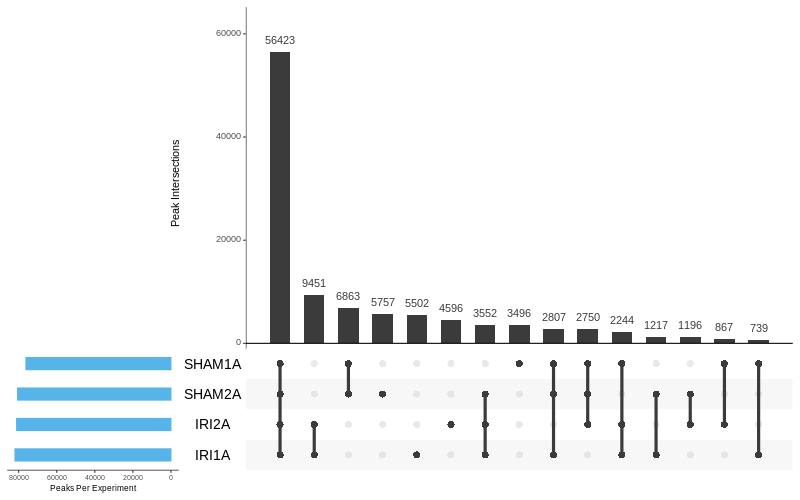

In [102]:
%%R  -h 500 -w 800 -u px
upset(peak_intersections, sets = c("IRI1A", "IRI2A", "SHAM1A", "SHAM2A"), sets.bar.color = "#56B4E9",
order.by = "freq", empty.intersections = "on",  number.angles = 0, point.size = 3, line.size = 1.5, 
    mainbar.y.label = "Peak Intersections", sets.x.label = "Peaks Per Experiment", 
    text.scale = c(1.3, 1.3, 1, 1, 2, 1.75))
    # c(intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars)

# Differential peak calling with DESeq2

In [20]:
%%R
bamsToCount <- dir("../../004_deeptools", full.names = TRUE, pattern = ".*\\.blfiltered.bam$")
bamsToCount

[1] "../../004_deeptools/IRI1A_processed.blfiltered.bam" 
[2] "../../004_deeptools/IRI2A_processed.blfiltered.bam" 
[3] "../../004_deeptools/Sham1A_processed.blfiltered.bam"
[4] "../../004_deeptools/Sham2A_processed.blfiltered.bam"


In [9]:
%%R
load("./reducedConsensus.GObj.RData")
consensusToCount <- reducedConsensus
consensusToCount

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Positi

GRanges object with 107460 ranges and 5 metadata columns:
           seqnames          ranges strand |     IRI1A     IRI2A    SHAM1A
              <Rle>       <IRanges>  <Rle> | <numeric> <numeric> <numeric>
       [1]     chr1 3116593-3117640      * |         0         0         1
       [2]     chr1 3119338-3121591      * |         1         1         1
       [3]     chr1 3126063-3126476      * |         0         0         0
       [4]     chr1 3154842-3157891      * |         0         0         1
       [5]     chr1 3176551-3176879      * |         0         0         0
       ...      ...             ...    ... .       ...       ...       ...
  [107456]     chrY 1254838-1255276      * |         0         0         1
  [107457]     chrY 2308813-2309456      * |         0         0         1
  [107458]     chrY 5670911-5671236      * |         0         0         1
  [107459]     chrY 5920093-5920381      * |         1         0         0
  [107460]     chrY 9389661-9390192      *

In [10]:
%%R
regionsToCount <- data.frame(GeneID = paste("ID", seqnames(consensusToCount), start(consensusToCount), end(consensusToCount), sep = "_"), 
                             Chr = seqnames(consensusToCount), Start = start(consensusToCount), End = end(consensusToCount), Strand = strand(consensusToCount))
head(regionsToCount)

                   GeneID  Chr   Start     End Strand
1 ID_chr1_3116593_3117640 chr1 3116593 3117640      *
2 ID_chr1_3119338_3121591 chr1 3119338 3121591      *
3 ID_chr1_3126063_3126476 chr1 3126063 3126476      *
4 ID_chr1_3154842_3157891 chr1 3154842 3157891      *
5 ID_chr1_3176551_3176879 chr1 3176551 3176879      *
6 ID_chr1_3247295_3247547 chr1 3247295 3247547      *


In [11]:
%%R
library(Rsubread)

In [2]:
%%R
#save.image(file = "./200222_backup.RData")
load("./200222_backup.RData")

In [30]:
%%R
fcResults <- featureCounts(bamsToCount, annot.ext = regionsToCount, isPairedEnd = TRUE, countMultiMappingReads = FALSE, minFragLength=0, maxFragLength = 200)
myCounts <- fcResults$counts
colnames(myCounts) <- c("IRI1A", "IRI2A", "SHAM1A", "SHAM2A")
save(myCounts, file = "featureCountsFromATACForDESeq2.RData")


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                           o IRI1A_processed.blfiltered.bam                 ||
||                           o IRI2A_processed.blfiltered.bam                 ||
||                           o Sham1A_processed.blfiltered.bam                ||
||                           o Sham2A_processed.blfil

In [31]:
%%R
library(DESeq2)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



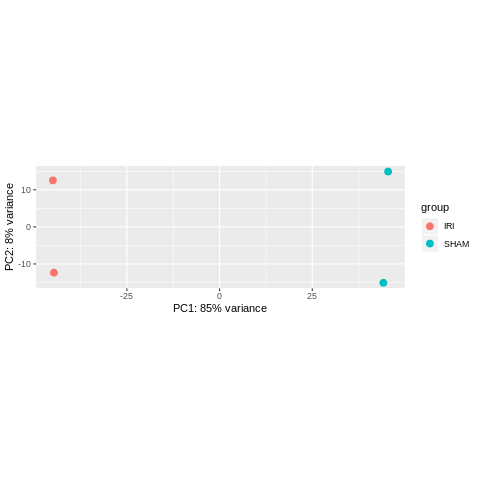

In [32]:
%%R
load("featureCountsFromATACForDESeq2.RData")
metaData <- data.frame(Group, row.names = colnames(myCounts))
atacDDS <- DESeqDataSetFromMatrix(myCounts, metaData, ~Group, rowRanges = consensusToCount)
atacDDS <- DESeq(atacDDS)
atac_Rlog <- rlog(atacDDS)
plotPCA(atac_Rlog, intgroup = "Group", ntop = nrow(atac_Rlog))

In [33]:
%%R
library(BSgenome.Mmusculus.UCSC.mm10)
library(tracktables)

IRISHAM <- results(atacDDS, c("Group", "IRI", "SHAM"), format = "GRanges")
IRISHAM <- IRISHAM[order(IRISHAM$pvalue)]
IRISHAM

GRanges object with 107460 ranges and 6 metadata columns:
                               seqnames              ranges strand |
                                  <Rle>           <IRanges>  <Rle> |
     ID_chr3_14348976_14349651     chr3   14348976-14349651      * |
     ID_chr8_60523308_60526371     chr8   60523308-60526371      * |
     ID_chr5_31576210_31577281     chr5   31576210-31577281      * |
   ID_chr6_133855762_133856322     chr6 133855762-133856322      * |
      ID_chr16_4040073_4042060    chr16     4040073-4042060      * |
                           ...      ...                 ...    ... .
    ID_chr12_85522703_85524375    chr12   85522703-85524375      * |
     ID_chr2_27283604_27285031     chr2   27283604-27285031      * |
  ID_chr12_119222433_119222702    chr12 119222433-119222702      * |
     ID_chr6_13600650_13602106     chr6   13600650-13602106      * |
     ID_chr2_38375917_38376373     chr2   38375917-38376373      * |
                                       baseMe

Total 107,460 regions were calculated

In [34]:
%%R
IRISHAM_df <- as.data.frame(IRISHAM)
write.csv(IRISHAM_df, "./IRISHAM.DESeq2.nofilter.bed", row.names=FALSE)
head(IRISHAM_df)

                            seqnames     start       end width strand baseMean
ID_chr3_14348976_14349651       chr3  14348976  14349651   676      * 397.2804
ID_chr8_60523308_60526371       chr8  60523308  60526371  3064      * 339.2852
ID_chr5_31576210_31577281       chr5  31576210  31577281  1072      * 310.5216
ID_chr6_133855762_133856322     chr6 133855762 133856322   561      * 254.8942
ID_chr16_4040073_4042060       chr16   4040073   4042060  1988      * 512.6076
ID_chr19_18890198_18891440     chr19  18890198  18891440  1243      * 315.7975
                            log2FoldChange     lfcSE      stat       pvalue
ID_chr3_14348976_14349651        -4.386188 0.2452603 -17.88381 1.576833e-71
ID_chr8_60523308_60526371        -3.820958 0.2423350 -15.76726 5.227171e-56
ID_chr5_31576210_31577281         3.312509 0.2190040  15.12534 1.102353e-51
ID_chr6_133855762_133856322      -3.863020 0.2565330 -15.05857 3.032704e-51
ID_chr16_4040073_4042060         -2.428575 0.1621836 -14.97423 1.08

In [35]:
%%R
save(IRISHAM, file = "IRISHAM.DESeq2.nofilter.GrangeObj.RData")

Open region with +- 500bp protomoter reagion and FDR < 0.05

In [36]:
%%R
library(TxDb.Mmusculus.UCSC.mm10.knownGene)

In [41]:
%%R
TxDb.Mmusculus.UCSC.mm10.knownGene

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: UCSC
# Genome: mm10
# Organism: Mus musculus
# Taxonomy ID: 10090
# UCSC Table: knownGene
# UCSC Track: GENCODE VM23
# Resource URL: http://genome.ucsc.edu/
# Type of Gene ID: Entrez Gene ID
# Full dataset: yes
# miRBase build ID: NA
# transcript_nrow: 142446
# exon_nrow: 447558
# cds_nrow: 243727
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2019-10-21 20:52:26 +0000 (Mon, 21 Oct 2019)
# GenomicFeatures version at creation time: 1.37.4
# RSQLite version at creation time: 2.1.2
# DBSCHEMAVERSION: 1.2


### Filtering with padj < 0.05

In [47]:
%%R
IRISHAM_FDR <- IRISHAM[(!is.na(IRISHAM$padj) & IRISHAM$padj < 0.05)]

write.csv(as.data.frame(IRISHAM_FDR), "./IRISHAM.DESeq2.padj.05.filter.bed", row.names=FALSE)
IRISHAM_FDR

GRanges object with 26516 ranges and 6 metadata columns:
                              seqnames              ranges strand |
                                 <Rle>           <IRanges>  <Rle> |
    ID_chr3_14348976_14349651     chr3   14348976-14349651      * |
    ID_chr8_60523308_60526371     chr8   60523308-60526371      * |
    ID_chr5_31576210_31577281     chr5   31576210-31577281      * |
  ID_chr6_133855762_133856322     chr6 133855762-133856322      * |
     ID_chr16_4040073_4042060    chr16     4040073-4042060      * |
                          ...      ...                 ...    ... .
    ID_chr6_66942981_66946082     chr6   66942981-66946082      * |
    ID_chr5_51536508_51537848     chr5   51536508-51537848      * |
   ID_chr19_43674561_43675939    chr19   43674561-43675939      * |
   ID_chr18_40113389_40114032    chr18   40113389-40114032      * |
   ID_chr12_30627869_30629145    chr12   30627869-30629145      * |
                                      baseMean     log2Fold

26,516 "Differential" peaks (P-adj. < 0.05)

Padj < 0.05 AND Protmoter  +/- 500 bp

In [40]:
%%R
toOverLap <- promoters(TxDb.Mmusculus.UCSC.mm10.knownGene, 500, 500)
toOverLap

GRanges object with 142446 ranges and 2 metadata columns:
                             seqnames          ranges strand |     tx_id
                                <Rle>       <IRanges>  <Rle> | <integer>
  ENSMUST00000193812.1           chr1 3072753-3073752      + |         1
  ENSMUST00000082908.1           chr1 3101516-3102515      + |         2
  ENSMUST00000192857.1           chr1 3252257-3253256      + |         3
  ENSMUST00000161581.1           chr1 3466087-3467086      + |         4
  ENSMUST00000192183.1           chr1 3531295-3532294      + |         5
                   ...            ...             ...    ... .       ...
  ENSMUST00000184505.1 chrUn_GL456381     16222-17221      - |    142442
  ENSMUST00000178705.1 chrUn_GL456385     30743-31742      + |    142443
  ENSMUST00000180206.1 chrUn_GL456385     32219-33218      + |    142444
  ENSMUST00000179505.7 chrUn_JH584304     59168-60167      - |    142445
  ENSMUST00000178343.1 chrUn_JH584304     59191-60190      - |    

In [38]:
%%R
IRISHAM.filtered <- IRISHAM[(!is.na(IRISHAM$padj) & 
    IRISHAM$padj < 0.05) & IRISHAM %over% toOverLap ]

#makebedtable(IRISHAM.filtered, "IRISHAM.filtered.promoter.500bp.padj.05.html", "./")
save(IRISHAM.filtered, file = "IRISHAM.DESeq2.promoter500bp.padj.05.filter.GrangeObj.RData")
IRISHAM.filtered

GRanges object with 4363 ranges and 6 metadata columns:
                              seqnames              ranges strand |
                                 <Rle>           <IRanges>  <Rle> |
    ID_chr3_90586768_90588430     chr3   90586768-90588430      * |
  ID_chr4_138877003_138878354     chr4 138877003-138878354      * |
  ID_chr3_135521858_135522953     chr3 135521858-135522953      * |
  ID_chr6_133853114_133855088     chr6 133853114-133855088      * |
   ID_chr13_35395157_35396143    chr13   35395157-35396143      * |
                          ...      ...                 ...    ... .
   ID_chr12_80183896_80184505    chr12   80183896-80184505      * |
  ID_chr2_102549781_102552743     chr2 102549781-102552743      * |
  ID_chr1_118627542_118628775     chr1 118627542-118628775      * |
  ID_chr3_126923695_126924441     chr3 126923695-126924441      * |
   ID_chr19_43674561_43675939    chr19   43674561-43675939      * |
                                      baseMean     log2FoldC

4,363 differnetial peaks in promoter +/- 500 bp

In [39]:
%%R
IRISHAM_filtered_df <- as.data.frame(IRISHAM)
write.csv(IRISHAM_filtered_df, "./IRISHAM.DESeq2.promoter500bp.padj.05.filter.bed", row.names=FALSE)
head(IRISHAM_filtered_df)

                            seqnames     start       end width strand baseMean
ID_chr3_14348976_14349651       chr3  14348976  14349651   676      * 397.2804
ID_chr8_60523308_60526371       chr8  60523308  60526371  3064      * 339.2852
ID_chr5_31576210_31577281       chr5  31576210  31577281  1072      * 310.5216
ID_chr6_133855762_133856322     chr6 133855762 133856322   561      * 254.8942
ID_chr16_4040073_4042060       chr16   4040073   4042060  1988      * 512.6076
ID_chr19_18890198_18891440     chr19  18890198  18891440  1243      * 315.7975
                            log2FoldChange     lfcSE      stat       pvalue
ID_chr3_14348976_14349651        -4.386188 0.2452603 -17.88381 1.576833e-71
ID_chr8_60523308_60526371        -3.820958 0.2423350 -15.76726 5.227171e-56
ID_chr5_31576210_31577281         3.312509 0.2190040  15.12534 1.102353e-51
ID_chr6_133855762_133856322      -3.863020 0.2565330 -15.05857 3.032704e-51
ID_chr16_4040073_4042060         -2.428575 0.1621836 -14.97423 1.08

## Peak annotation

In [42]:
%%R
library(clusterProfiler)
library(ChIPseeker)

R[write to console]: 

R[write to console]: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

R[write to console]: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

R[write to console]: 
Attaching package: ‘clusterProfiler’


R[write to console]: The following object is masked from ‘package:DelayedArray’:

    simplify


R[write to console]: ChIPseeker v1.22.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 201

In [335]:
%%R
head(as.data.frame(genes(TxDb.Mmusculus.UCSC.mm10.knownGene)))

          seqnames     start       end width strand   gene_id
100009600     chr9  21062393  21073096 10704      - 100009600
100009609     chr7  84935565  84964115 28551      - 100009609
100009614    chr10  77711457  77712009   553      + 100009614
100009664    chr11  45808087  45841171 33085      + 100009664
100012        chr4 144157557 144162663  5107      -    100012
100017        chr4 134741554 134768024 26471      -    100017


In [336]:
%%R
write.table(as.data.frame(genes(TxDb.Mmusculus.UCSC.mm10.knownGene)), "TxDb.Mmusculus.UCSC.mm10.knownGene.genes.bed", sep='\t', row.names = FALSE, col.names = FALSE)

In [45]:
%%R
anno_IRISHAM <- annotatePeak(IRISHAM, TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene)
anno_IRISHAM

>> preparing features information...		 2020-02-22 12:37:07 PM 
>> identifying nearest features...		 2020-02-22 12:37:07 PM 
>> calculating distance from peak to TSS...	 2020-02-22 12:37:13 PM 
>> assigning genomic annotation...		 2020-02-22 12:37:13 PM 
>> assigning chromosome lengths			 2020-02-22 12:37:20 PM 
>> done...					 2020-02-22 12:37:20 PM 
Annotated peaks generated by ChIPseeker
107460/107460  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 18.0504374
10   Promoter (1-2kb)  3.7158012
11   Promoter (2-3kb)  3.4142937
4              5' UTR  0.3564117
3              3' UTR  2.4176438
1            1st Exon  1.9123395
7          Other Exon  4.2434394
2          1st Intron 12.0361065
8        Other Intron 22.1505677
6  Downstream (<=300)  1.0310813
5   Distal Intergenic 30.6718779


In [48]:
%%R
anno_IRISHAM_FDR <- annotatePeak(IRISHAM_FDR, TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene)
anno_IRISHAM_FDR

>> preparing features information...		 2020-02-22 12:40:11 PM 
>> identifying nearest features...		 2020-02-22 12:40:11 PM 
>> calculating distance from peak to TSS...	 2020-02-22 12:40:12 PM 
>> assigning genomic annotation...		 2020-02-22 12:40:12 PM 
>> assigning chromosome lengths			 2020-02-22 12:40:19 PM 
>> done...					 2020-02-22 12:40:19 PM 
Annotated peaks generated by ChIPseeker
26516/26516  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 14.9381506
10   Promoter (1-2kb)  3.6619400
11   Promoter (2-3kb)  3.4281189
4              5' UTR  0.3243325
3              3' UTR  2.1232463
1            1st Exon  1.9912506
7          Other Exon  4.2540353
2          1st Intron 12.2567506
8        Other Intron 22.1715191
6  Downstream (<=300)  1.0257957
5   Distal Intergenic 33.8248605


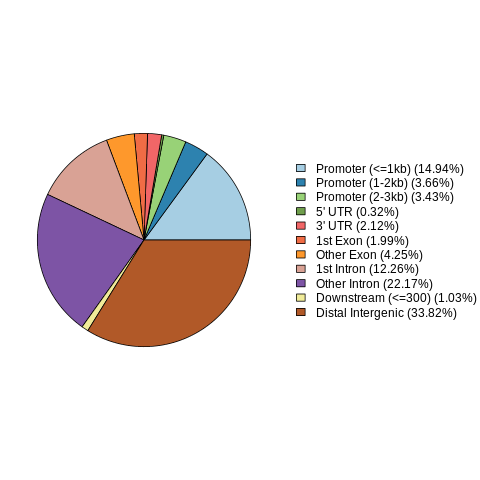

In [54]:
%%R
plotAnnoPie(anno_IRISHAM_FDR)

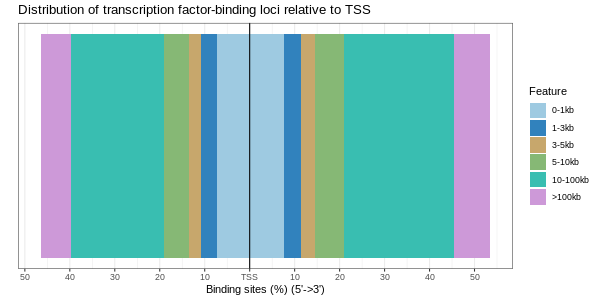

In [57]:
%%R -h 300 -w 600 -u px
plotDistToTSS(anno_IRISHAM_FDR)

IRISHAM Padj. < 0.05 AND abs(distanceToTSS) < 500

In [129]:
%%R
anno_IRISHAM_FDR.grange <- as.GRanges(anno_IRISHAM_FDR)
TSS_anno_IRISHAM_FDR.nearTSS <- anno_IRISHAM_FDR.grange[abs(anno_IRISHAM_FDR.grange$distanceToTSS) < 500]
TSS_anno_IRISHAM_FDR.distTSS <- anno_IRISHAM_FDR.grange[abs(anno_IRISHAM_FDR.grange$distanceToTSS) >= 500]

# Grange objects for TSS/noTSS

- TSS_anno_IRISHAM_FDR.nearTSS
- TSS_anno_IRISHAM_FDR.distTSS

In [130]:
%%R
TSS_anno_IRISHAM_FDR.nearTSS

GRanges object with 3641 ranges and 15 metadata columns:
                              seqnames              ranges strand |
                                 <Rle>           <IRanges>  <Rle> |
    ID_chr3_90586768_90588430     chr3   90586768-90588430      * |
  ID_chr4_138877003_138878354     chr4 138877003-138878354      * |
  ID_chr3_135521858_135522953     chr3 135521858-135522953      * |
  ID_chr6_133853114_133855088     chr6 133853114-133855088      * |
   ID_chr13_34112335_34113380    chr13   34112335-34113380      * |
                          ...      ...                 ...    ... .
  ID_chr7_103211975_103212560     chr7 103211975-103212560      * |
   ID_chr12_80183896_80184505    chr12   80183896-80184505      * |
  ID_chr2_102549781_102552743     chr2 102549781-102552743      * |
  ID_chr1_118627542_118628775     chr1 118627542-118628775      * |
   ID_chr19_43674561_43675939    chr19   43674561-43675939      * |
                                      baseMean     log2Fold

In [229]:
%%R
TSS_anno_IRISHAM_FDR.distTSS

GRanges object with 22875 ranges and 15 metadata columns:
                              seqnames              ranges strand |
                                 <Rle>           <IRanges>  <Rle> |
    ID_chr3_14348976_14349651     chr3   14348976-14349651      * |
    ID_chr8_60523308_60526371     chr8   60523308-60526371      * |
    ID_chr5_31576210_31577281     chr5   31576210-31577281      * |
  ID_chr6_133855762_133856322     chr6 133855762-133856322      * |
     ID_chr16_4040073_4042060    chr16     4040073-4042060      * |
                          ...      ...                 ...    ... .
   ID_chr17_43832582_43833340    chr17   43832582-43833340      * |
    ID_chr6_66942981_66946082     chr6   66942981-66946082      * |
    ID_chr5_51536508_51537848     chr5   51536508-51537848      * |
   ID_chr18_40113389_40114032    chr18   40113389-40114032      * |
   ID_chr12_30627869_30629145    chr12   30627869-30629145      * |
                                      baseMean     log2Fol

## Biomart gene description with entrez gene id

In [184]:
%%R
library(biomaRt)
mart <- useDataset("mmusculus_gene_ensembl", useMart("ensembl"))

### Annotation of nearTSS 500+/- padj < 0.05 with BiomaRt

In [222]:
%%R
TSS_anno_IRISHAM_FDR.nearTSS.df = as.data.frame(TSS_anno_IRISHAM_FDR.nearTSS)
head(TSS_anno_IRISHAM_FDR.nearTSS.df,3)["geneId"]

                            geneId
ID_chr3_90586768_90588430    20197
ID_chr4_138877003_138878354  26970
ID_chr3_135521858_135522953 110173


In [213]:
%%R
genes <- getBM(filters="entrezgene_id", attributes=c("entrezgene_id", "description", 'mgi_symbol'), 
               values=TSS_anno_IRISHAM_FDR.nearTSS.df["geneId"], mart=mart)
head(genes,10)

R[write to console]: 
R[write to console]: Batch submitting query [=======>-----------------------]  25% eta:  2s
R[write to console]: 
R[write to console]: Batch submitting query [===============>---------------]  50% eta:  1s
R[write to console]: 
R[write to console]: Batch submitting query [======================>--------]  75% eta:  1s
                                                                      
R[write to console]: 


   entrezgene_id
1      100036521
2      100039027
3         100072
4         100121
5         100213
6      100328588
7         100494
8      100503890
9         100532
10        100986
                                                                            description
1  UMAP1-MVP12 associated (UMA) domain containing 1 [Source:MGI Symbol;Acc:MGI:3840148]
2                               predicted gene 2011 [Source:MGI Symbol;Acc:MGI:3780180]
3      calmodulin binding transcription activator 1 [Source:MGI Symbol;Acc:MGI:2140230]
4                         tudor domain containing 7 [Source:MGI Symbol;Acc:MGI:2140279]
5                   RUN and SH3 domain containing 2 [Source:MGI Symbol;Acc:MGI:2140371]
6                            interleukin 4 induced 1 [Source:MGI Symbol;Acc:MGI:109552]
7                   zinc finger, AN1-type domain 2A [Source:MGI Symbol;Acc:MGI:2140729]
8                                    PET100 homolog [Source:MGI Symbol;Acc:MGI:3615306]
9                    

In [223]:
%%R
TSS_anno_IRISHAM_FDR.nearTSS.df <- merge(TSS_anno_IRISHAM_FDR.nearTSS.df, genes, by.x="geneId", by.y="entrezgene_id")
head(unique(TSS_anno_IRISHAM_FDR.nearTSS.df),5)

     geneId seqnames     start       end width strand   baseMean log2FoldChange
1 100036521     chr6   8258779   8259954  1176      * 1328.98261     -0.5004220
2 100037258    chr14 118937380 118938726  1347      * 1507.55579     -0.4609992
3 100038417    chr18  62614920  62615754   835      *   48.09983      1.3326599
4 100039027     chr3  40846365  40847387  1023      * 2675.10414     -0.4077714
6 100039027     chr3  40893755  40894722   968      * 2280.43270     -0.3755250
       lfcSE      stat       pvalue         padj       annotation geneChr
1 0.11355889 -4.406718 1.049486e-05 0.0001517870 Promoter (<=1kb)       6
2 0.11556527 -3.989081 6.632983e-05 0.0007223881 Promoter (<=1kb)      14
3 0.44045024  3.025676 2.480777e-03 0.0141890783 Promoter (<=1kb)      18
4 0.09783177 -4.168088 3.071655e-05 0.0003784163 Promoter (<=1kb)       3
6 0.09861538 -3.807976 1.401088e-04 0.0013475942 Promoter (<=1kb)       3
  geneStart   geneEnd geneLength geneStrand         transcriptId distanceToT

In [227]:
%%R
write.csv(unique(TSS_anno_IRISHAM_FDR.nearTSS.df), "anno_IRISHAM.DESeq2.TSS.near500bp.padj.05.filter.csv")

### Annotation of distTSS 500+/- padj < 0.05 with BiomaRt

In [203]:
%%R
TSS_anno_IRISHAM_FDR.distTSS

GRanges object with 22875 ranges and 15 metadata columns:
                              seqnames              ranges strand |
                                 <Rle>           <IRanges>  <Rle> |
    ID_chr3_14348976_14349651     chr3   14348976-14349651      * |
    ID_chr8_60523308_60526371     chr8   60523308-60526371      * |
    ID_chr5_31576210_31577281     chr5   31576210-31577281      * |
  ID_chr6_133855762_133856322     chr6 133855762-133856322      * |
     ID_chr16_4040073_4042060    chr16     4040073-4042060      * |
                          ...      ...                 ...    ... .
   ID_chr17_43832582_43833340    chr17   43832582-43833340      * |
    ID_chr6_66942981_66946082     chr6   66942981-66946082      * |
    ID_chr5_51536508_51537848     chr5   51536508-51537848      * |
   ID_chr18_40113389_40114032    chr18   40113389-40114032      * |
   ID_chr12_30627869_30629145    chr12   30627869-30629145      * |
                                      baseMean     log2Fol

3641(nearTSS) + 22,875 (distTSS) = 26,516 (Total)

In [219]:
%%R
TSS_anno_IRISHAM_FDR.distTSS.df <- as.data.frame(TSS_anno_IRISHAM_FDR.distTSS)
head(TSS_anno_IRISHAM_FDR.distTSS.df,3)["geneId"]

                          geneId
ID_chr3_14348976_14349651 622229
ID_chr8_60523308_60526371  23923
ID_chr5_31576210_31577281 100740


In [206]:
%%R
genes <- getBM(filters="entrezgene_id", attributes=c("entrezgene_id", "description", 'mgi_symbol',"ensembl_gene_id"), 
               values=TSS_anno_IRISHAM_FDR.distTSS.df["geneId"], mart=mart)
head(genes,3)

R[write to console]: 
R[write to console]: Batch submitting query [>------------------------------]   4% eta: 19s
R[write to console]: 
R[write to console]: Batch submitting query [==>----------------------------]   9% eta: 15s
R[write to console]: 
R[write to console]: Batch submitting query [===>---------------------------]  13% eta: 13s
R[write to console]: 
R[write to console]: Batch submitting query [====>--------------------------]  17% eta: 12s
R[write to console]: 
R[write to console]: Batch submitting query [======>------------------------]  22% eta: 12s
R[write to console]: 
R[write to console]: Batch submitting query [=======>-----------------------]  26% eta: 11s
R[write to console]: 
R[write to console]: Batch submitting query [========>----------------------]  30% eta: 10s
R[write to console]: 
R[write to console]: Batch submitting query [==========>--------------------]  35% eta:  9s
R[write to console]: 
R[write to console]: Batch submitting query [===========>---------

  entrezgene_id
1     100040049
2     100040724
3     100101919
                                                             description
1 small integral membrane protein 38 [Source:MGI Symbol;Acc:MGI:1916283]
2              miRNA containing gene [Source:MGI Symbol;Acc:MGI:3781106]
3   dynein, axonemal, heavy chain 7C [Source:MGI Symbol;Acc:MGI:3639762]
  mgi_symbol    ensembl_gene_id
1     Smim38 ENSMUSG00000109305
2       Mirg ENSMUSG00000097391
3     Dnah7c ENSMUSG00000101337


In [220]:
%%R
TSS_anno_IRISHAM_FDR.distTSS.df <- merge(TSS_anno_IRISHAM_FDR.distTSS.df, genes, by.x="geneId", by.y="entrezgene_id")
head(TSS_anno_IRISHAM_FDR.distTSS.df,3)

     geneId seqnames   start     end width strand baseMean log2FoldChange
1 100036521     chr6 8376849 8377942  1094      * 25.96688      1.6549831
2 100036521     chr6 8346550 8347486   937      * 32.51415      1.3969429
3 100036521     chr6 8345421 8346527  1107      * 88.00697      0.9981447
      lfcSE     stat      pvalue       padj
1 0.6313202 2.621464 0.008755308 0.03830960
2 0.5368966 2.601884 0.009271311 0.04003758
3 0.3217113 3.102610 0.001918224 0.01154848
                                                     annotation geneChr
1 Exon (ENSMUST00000159919.1/ENSMUST00000159919.1, exon 1 of 1)       6
2        Intron (ENSMUST00000159335.7/100036521, intron 2 of 4)       6
3        Intron (ENSMUST00000159335.7/100036521, intron 2 of 4)       6
  geneStart geneEnd geneLength geneStrand         transcriptId distanceToTSS
1   8419678 8428238       8561          1 ENSMUST00000160253.1        -41736
2   8419678 8428238       8561          1 ENSMUST00000160253.1        -72192
3   84196

In [221]:
%%R
write.csv(unique(TSS_anno_IRISHAM_FDR.distTSS.df), "anno_IRISHAM.DESeq2.TSS.dist500bp.padj.05.filter.csv")

### Promoter +/- 500 bp region

In [46]:
%%R
anno_IRISHAM.filtered <- annotatePeak(IRISHAM.filtered, TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene)
anno_IRISHAM.filtered

>> preparing features information...		 2020-02-22 12:37:21 PM 
>> identifying nearest features...		 2020-02-22 12:37:21 PM 
>> calculating distance from peak to TSS...	 2020-02-22 12:37:21 PM 
>> assigning genomic annotation...		 2020-02-22 12:37:21 PM 
>> assigning chromosome lengths			 2020-02-22 12:37:28 PM 
>> done...					 2020-02-22 12:37:28 PM 
Annotated peaks generated by ChIPseeker
4363/4363  peaks were annotated
Genomic Annotation Summary:
              Feature   Frequency
9    Promoter (<=1kb) 83.74971350
10   Promoter (1-2kb)  0.82512033
11   Promoter (2-3kb)  0.64176026
4              5' UTR  0.29796012
3              3' UTR  0.50424020
1            1st Exon 10.15356406
7          Other Exon  0.98556039
2          1st Intron  0.59592024
8        Other Intron  0.71052028
6  Downstream (<=300)  0.02292001
5   Distal Intergenic  1.51272061


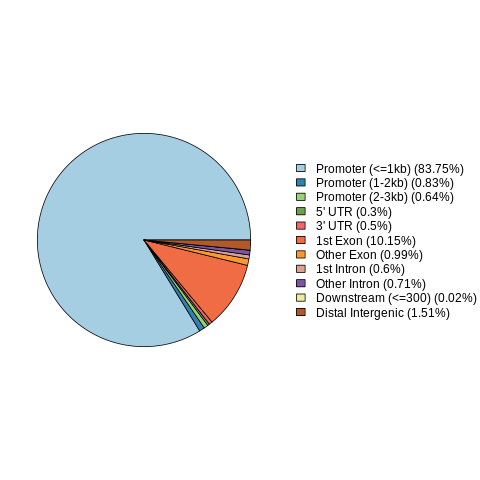

In [52]:
%%R
plotAnnoPie(anno_IRISHAM.filtered)

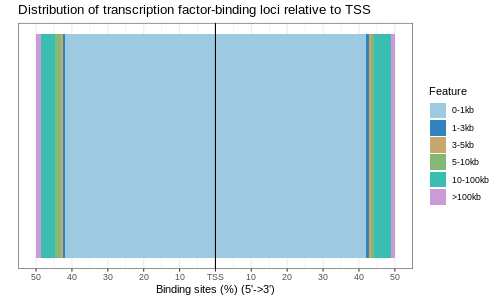

In [58]:
%%R -h 300 -w 500 -u px
plotDistToTSS(anno_IRISHAM.filtered)

In [59]:
%%R
anno_IRISHAM.filtered_df <- as.data.frame(anno_IRISHAM.filtered)
head(anno_IRISHAM.filtered_df, n=3)

  seqnames     start       end width strand baseMean log2FoldChange     lfcSE
1     chr3  90586768  90588430  1663      * 251.3443       3.330715 0.2391597
2     chr4 138877003 138878354  1352      * 233.3243       3.773988 0.2713980
3     chr3 135521858 135522953  1096      * 365.3853       2.353838 0.1830885
      stat       pvalue         padj       annotation geneChr geneStart
1 13.92674 4.358140e-44 4.683258e-40 Promoter (<=1kb)       3  90586952
2 13.90574 5.846224e-44 5.711229e-40 Promoter (<=1kb)       4 138877942
3 12.85629 7.929688e-38 2.938360e-34 Promoter (<=1kb)       3 135522935
    geneEnd geneLength geneStrand geneId          transcriptId distanceToTSS
1  90602524      15573          1  20197  ENSMUST00000200290.4             0
2 138882817       4876          1  26970 ENSMUST00000030531.13             0
3 135524559       1625          1 110173  ENSMUST00000134095.1             0


In [114]:
%%R
write.csv(anno_IRISHAM.filtered_df, "anno_IRISHAM.DESeq2.promoter500bp.padj.05.filter.csv")

## Volcano plots

In [61]:
%%R
library(ggpubr)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: magrittr



### All differential peak with P-adj. < 0.05

In [141]:
%%R
anno_IRISHAM_FDR_df = as.data.frame(anno_IRISHAM_FDR)
head(anno_IRISHAM_FDR_df,n=5)

  seqnames     start       end width strand baseMean log2FoldChange     lfcSE
1     chr3  14348976  14349651   676      * 397.2804      -4.386188 0.2452603
2     chr8  60523308  60526371  3064      * 339.2852      -3.820958 0.2423350
3     chr5  31576210  31577281  1072      * 310.5216       3.312509 0.2190040
4     chr6 133855762 133856322   561      * 254.8942      -3.863020 0.2565330
5    chr16   4040073   4042060  1988      * 512.6076      -2.428575 0.1621836
       stat       pvalue         padj
1 -17.88381 1.576833e-71 1.694465e-66
2 -15.76726 5.227171e-56 2.808559e-51
3  15.12534 1.102353e-51 3.948627e-47
4 -15.05857 3.032704e-51 8.147360e-47
5 -14.97423 1.082156e-50 2.325770e-46
                                           annotation geneChr geneStart
1                                   Distal Intergenic       3  14363117
2 Intron (ENSMUST00000079472.3/23923, intron 4 of 12)       8  60506511
3                                   Distal Intergenic       5  31569595
4               

In [145]:
%%R
anno_IRISHAM_FDR_df_volcano <- anno_IRISHAM_FDR_df[c("log2FoldChange")]
#head(anno_IRISHAM.filtered_df_alpha[c("log2FoldChange")])
neglogpadj <- (-1)*log(anno_IRISHAM_FDR_df['padj'],10)
absDistanceToTSS <- abs(anno_IRISHAM_FDR_df["distanceToTSS"])
anno_IRISHAM_FDR_df_volcano <- cbind(neglogpadj, absDistanceToTSS, anno_IRISHAM_FDR_df_volcano)
write.csv(anno_IRISHAM_FDR_df_volcano, "./anno_IRISHAM.padj.05.volcano.csv")
head(anno_IRISHAM_FDR_df_volcano, n=3)

      padj distanceToTSS log2FoldChange
1 65.77097         13466      -4.386188
2 50.55152         16797      -3.820958
3 46.40355          4813       3.312509


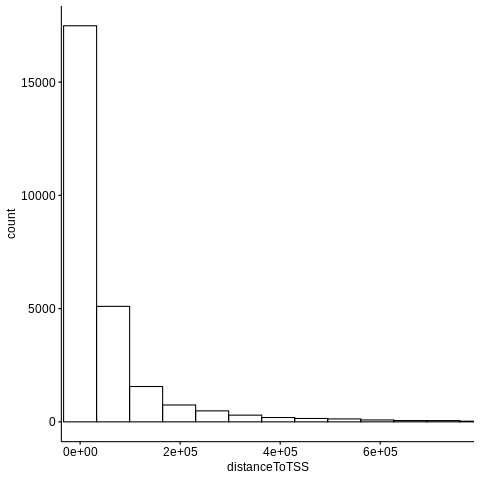

In [155]:
%%R
gghistogram(anno_IRISHAM_FDR_df_volcano, x='distanceToTSS', xlim=c(0,750000))

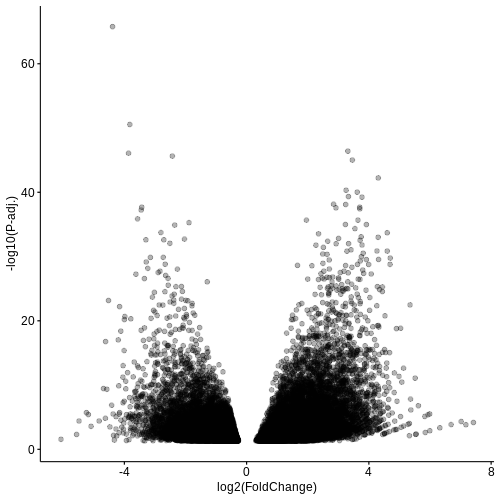

In [177]:
%%R -h 500 -w 500 -u px
ggscatter(anno_IRISHAM_FDR_df_volcano, y='padj' ,x='log2FoldChange', alpha=0.3) + ylab("-log10(P-adj.)") + xlab("log2(FoldChange)")

In [306]:
%%R
numberOfTopPeaks = 1000
#UpRegulatedGenes1k.nearTSS <- unique(as.data.frame(as.GRanges(anno_IRISHAM_FDR)[as.GRanges(anno_IRISHAM_FDR)$log2FoldChange > 0])$geneId)
#byDayTime[order(-byDayTime$count),][1:10,]

AllGenes1k.nearTSS = unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(-abs(TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange")),])[1:numberOfTopPeaks,]$geneId # abs highest 10
UpRegulatedGenes1k.nearTSS = unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(-TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #highest 10
DownRegulatedGenes1k.nearTSS = unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #lowest 10

AllGenes1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(-abs(TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange")),])[1:numberOfTopPeaks,]$geneId # abs highest 10
UpRegulatedGenes1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(-TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #highest 10
DownRegulatedGenes1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #lowest 10

In [307]:
%%R
#unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #lowest 10
#unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(-TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,]$geneId #highest 10
#unique(TSS_anno_IRISHAM_FDR.nearTSS.df[order(-abs(TSS_anno_IRISHAM_FDR.nearTSS.df$"log2FoldChange")),])[1:numberOfTopPeaks,]$geneId # abs highest 10

NULL


## For 3,641(nearTSS): Padj<0.05, TSS +/- 500bp - GO analysis,

In [308]:
%%R
# GO0: 1000 peaks from all:
go0 <- enrichGO(AllGenes1k.nearTSS, OrgDb = "org.Mm.eg.db", ont = "BP", maxGSSize = 5000)

# GO1: UP-regulated
go1 <- enrichGO(UpRegulatedGenes1k.nearTSS, OrgDb = "org.Mm.eg.db", ont = "BP", maxGSSize = 5000)

# GO2: Down-regulated
go2 <- enrichGO(DownRegulatedGenes1k.nearTSS, OrgDb = "org.Mm.eg.db", ont = "BP", maxGSSize = 5000)

In [309]:
%%R
head(go1, 10) %>% dplyr::select(ID, Description, pvalue, p.adjust)

                   ID                                     Description
GO:0048523 GO:0048523         negative regulation of cellular process
GO:0042221 GO:0042221                            response to chemical
GO:0051234 GO:0051234                   establishment of localization
GO:0009653 GO:0009653              anatomical structure morphogenesis
GO:0048731 GO:0048731                              system development
GO:0022610 GO:0022610                             biological adhesion
GO:0006810 GO:0006810                                       transport
GO:0032879 GO:0032879                      regulation of localization
GO:0006796 GO:0006796 phosphate-containing compound metabolic process
GO:0007155 GO:0007155                                   cell adhesion
                 pvalue     p.adjust
GO:0048523 1.511563e-16 6.418892e-13
GO:0042221 2.732435e-16 6.418892e-13
GO:0051234 3.407055e-16 6.418892e-13
GO:0009653 4.586576e-16 6.480832e-13
GO:0048731 2.770976e-15 3.132311e-12
GO:00226

In [310]:
%%R
head(go2, 10) %>% dplyr::select(ID, Description, pvalue, p.adjust)

                   ID                                      Description
GO:0044249 GO:0044249                    cellular biosynthetic process
GO:0048523 GO:0048523          negative regulation of cellular process
GO:0046483 GO:0046483                    heterocycle metabolic process
GO:0044281 GO:0044281                 small molecule metabolic process
GO:0006082 GO:0006082                   organic acid metabolic process
GO:0006139 GO:0006139 nucleobase-containing compound metabolic process
GO:0019752 GO:0019752                carboxylic acid metabolic process
GO:1901362 GO:1901362     organic cyclic compound biosynthetic process
GO:0065008 GO:0065008                 regulation of biological quality
GO:0044271 GO:0044271  cellular nitrogen compound biosynthetic process
                 pvalue     p.adjust
GO:0044249 1.062696e-16 4.287426e-13
GO:0048523 1.551729e-16 4.287426e-13
GO:0046483 2.453472e-15 4.519296e-12
GO:0044281 1.713740e-14 2.367532e-11
GO:0006082 3.239348e-14 3.580128e-

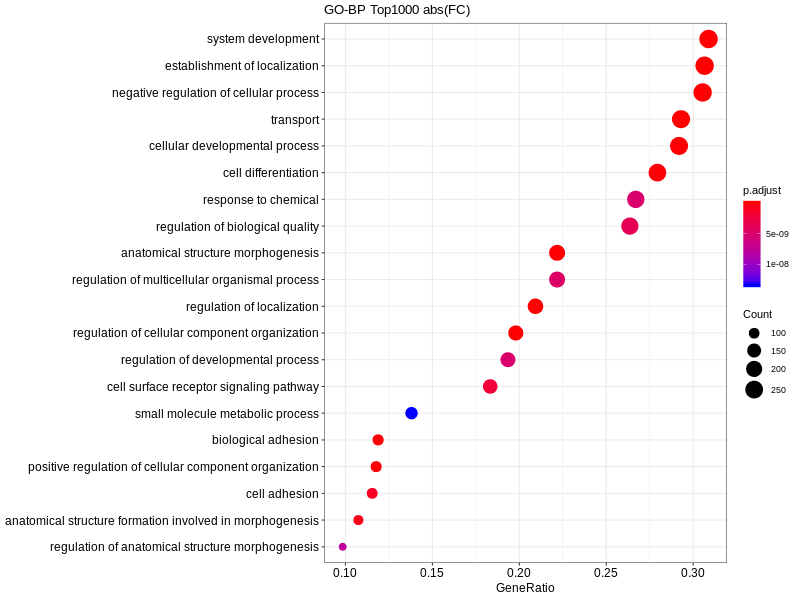

In [311]:
%%R -h 600 -w 800 -u px
dotplot(go0, showCategory=20) +ggtitle("GO-BP Top1000 abs(FC)")

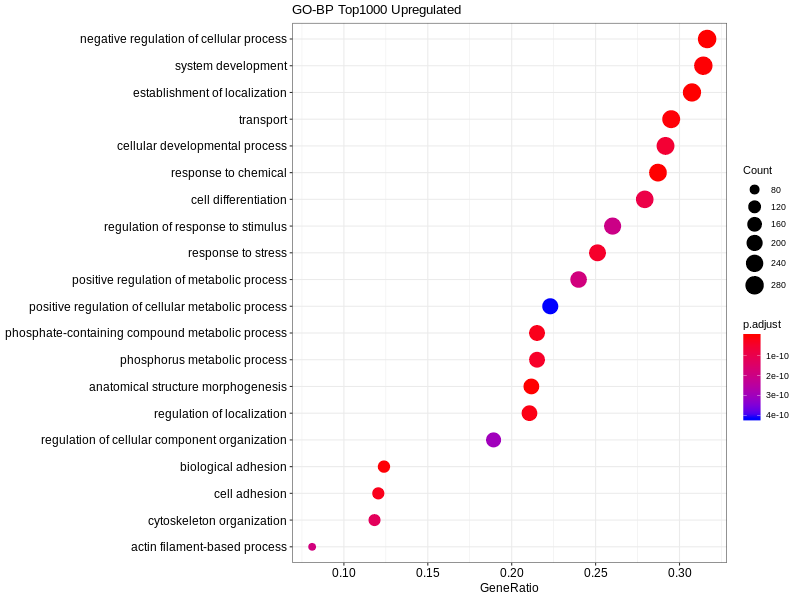

In [312]:
%%R -h 600 -w 800 -u px
dotplot(go1, showCategory=20) +ggtitle("GO-BP Top1000 Upregulated")

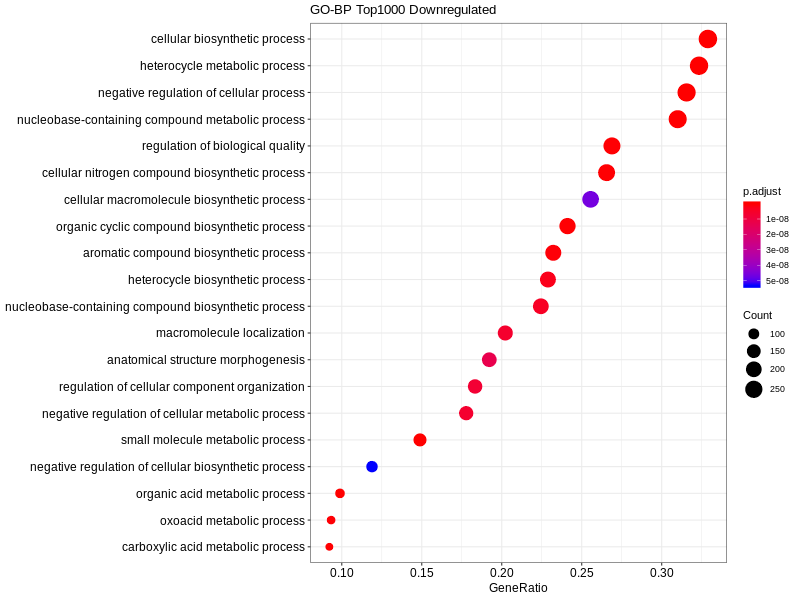

In [313]:
%%R -h 600 -w 800 -u px
dotplot(go2, showCategory=20) +ggtitle("GO-BP Top1000 Downregulated")

## Pathway analysis

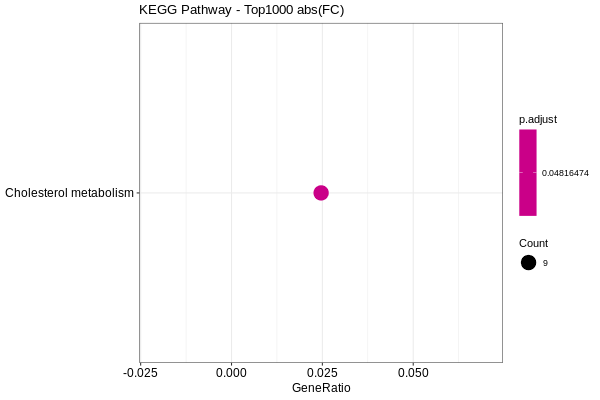

In [321]:
%%R -w 600 -h 400 -u px
kegg0 <- enrichKEGG(gene = AllGenes1k.nearTSS, organism = 'mmu', pvalueCutoff = 0.05)
dotplot(kegg0) + ggtitle("KEGG Pathway - Top1000 abs(FC)")

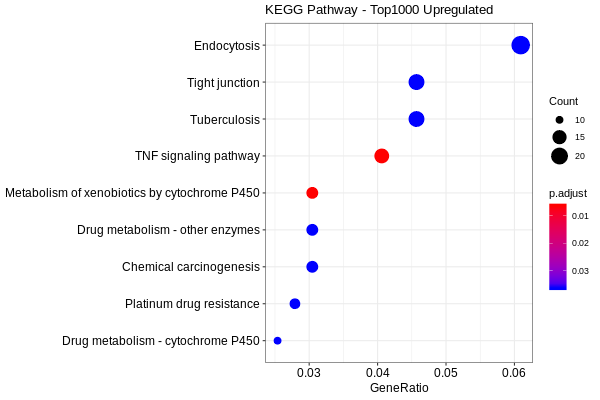

In [318]:
%%R -w 600 -h 400 -u px
kegg1 <- enrichKEGG(gene = UpRegulatedGenes1k.nearTSS, organism = 'mmu', pvalueCutoff = 0.05)
dotplot(kegg1) + ggtitle("KEGG Pathway - Top1000 Upregulated")

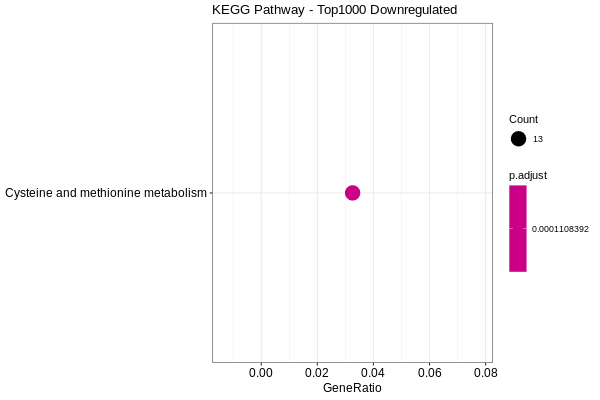

In [319]:
%%R  -w 600 -h 400 -u px
kegg2 <- enrichKEGG(gene = DownRegulatedGenes1k.nearTSS, organism = 'mmu', pvalueCutoff = 0.05)
dotplot(kegg2) +ggtitle("KEGG Pathway - Top1000 Downregulated")

## For 22,875 (distTSS): TSS > 500 bp - Motif analysis

In [327]:
%%R

AllRegions1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(-abs(TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange")),])[1:numberOfTopPeaks,] # abs highest 10
UpRegulatedRegions1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(-TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,] #highest 10
DownRegulatedRegions1k.distTSS = unique(TSS_anno_IRISHAM_FDR.distTSS.df[order(TSS_anno_IRISHAM_FDR.distTSS.df$"log2FoldChange"),])[1:numberOfTopPeaks,] #lowest 10

In [332]:
%%R
write.table(subset(AllRegions1k.distTSS, select = -c(geneId)), "AllRegions1k.distTSS.bed", sep = "\t", row.names=FALSE)
write.table(subset(UpRegulatedRegions1k.distTSS, select = -c(geneId)), "UpRegulatedRegions1k.distTSS.bed", sep = "\t", row.names=FALSE)
write.table(subset(DownRegulatedRegions1k.distTSS, select = -c(geneId)), "DownRegulatedRegions1k.distTSS.bed", sep = "\t", row.names=FALSE)




In [228]:
%%R
library(motifmatchr)
library(GenomicRanges)
library(BSgenome)
library(chromVAR)
#BiocManager::install("BSgenome.Mmusculus.UCSC.mm10")
library(SummarizedExperiment)

R[write to console]: No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’



In [232]:
%%R
# load Mus musculus motif
jasparMotifs <- chromVAR:::getJasparMotifs(species = "Mus musculus", collection = "CORE") #Mus musculus, Taxonomy ID: 10090

- TSS_anno_IRISHAM_FDR.nearTSS
- TSS_anno_IRISHAM_FDR.distTSS

In [237]:
%%R
# Get motif matches for example motifs in peaks
motif_ix <- matchMotifs(jasparMotifs, TSS_anno_IRISHAM_FDR.nearTSS, genome = BSgenome.Mmusculus.UCSC.mm10)  # BSgenome.Mmusculus.UCSC.mm10
print(motif_ix)

class: RangedSummarizedExperiment 
dim: 3641 128 
metadata(0):
assays(1): motifMatches
rownames(3641): ID_chr3_90586768_90588430 ID_chr4_138877003_138878354
  ... ID_chr1_118627542_118628775 ID_chr19_43674561_43675939
rowData names(15): baseMean log2FoldChange ... transcriptId
  distanceToTSS
colnames(128): MA0004.1_Arnt MA0006.1_Ahr::Arnt ... MA0912.1_Hoxd3
  MA0913.1_Hoxd9
colData names(1): name


In [239]:
%%R
head(motifMatches(motif_ix)) # Extract matches matrix from SummarizedExperiment result

6 x 128 sparse Matrix of class "lgCMatrix"


R[write to console]:    [[ suppressing 128 column names ‘MA0004.1_Arnt’, ‘MA0006.1_Ahr::Arnt’, ‘MA0029.1_Mecom’ ... ]]



                                                                               
ID_chr3_90586768_90588430   . . . . . | . . . . . . . . | . . . | . . . . | . .
ID_chr4_138877003_138878354 . | . . . . . | . . . . . | . . | | . . . . . | . |
ID_chr3_135521858_135522953 . . | . . . . | . . . | . | . . . . | . . . . | . .
ID_chr6_133853114_133855088 . . . . . . . | . . . . . | | | . | | . . . . . . |
ID_chr13_34112335_34113380  . . . . . | . | . . . . . . | . . | . . . . . | . |
ID_chr5_64112226_64114211   . . . . . . . | . . . | . . | . . . . . . . | | . |
                                                                               
ID_chr3_90586768_90588430   | . . | . . . . . | | . . | . . | . | | . . . . | .
ID_chr4_138877003_138878354 . . . | . . . | . | | | . . | | . . . | . | . . | |
ID_chr3_135521858_135522953 . | . . | . . . . . . . . . . . . . . . | . . . . .
ID_chr6_133853114_133855088 . . . | . . . | . | | | . | | | . . . | . | . . . .
ID_chr13_34112335_34113380  . . . . . . 

In [234]:
%%R
head(motif_ix,2)

class: RangedSummarizedExperiment 
dim: 2 128 
metadata(0):
assays(1): motifMatches
rownames(2): ID_chr3_90586768_90588430 ID_chr4_138877003_138878354
rowData names(15): baseMean log2FoldChange ... transcriptId
  distanceToTSS
colnames(128): MA0004.1_Arnt MA0006.1_Ahr::Arnt ... MA0912.1_Hoxd3
  MA0913.1_Hoxd9
colData names(1): name


In [236]:
%%R
# Get motif positions within peaks for example motifs in peaks 
motif_pos <- matchMotifs(jasparMotifs,  TSS_anno_IRISHAM_FDR.nearTSS, genome = BSgenome.Mmusculus.UCSC.mm10, out = "positions")

In [238]:
%%R
print(motif_pos)

GRangesList object of length 128:
$MA0004.1_Arnt
GRanges object with 2566 ranges and 1 metadata column:
         seqnames            ranges strand |            score
            <Rle>         <IRanges>  <Rle> |        <numeric>
     [1]     chr8 70703166-70703171      + | 11.6466212014528
     [2]     chr8 70703166-70703171      - | 11.6466212014528
     [3]    chr16   4036996-4037001      + | 11.6466212014528
     [4]    chr16   4036996-4037001      - | 11.6466212014528
     [5]    chr13 55408784-55408789      + | 11.6466212014528
     ...      ...               ...    ... .              ...
  [2562]     chr5 28072117-28072122      - | 11.6466212014528
  [2563]     chr9 22070669-22070674      + | 11.6466212014528
  [2564]     chr9 22070669-22070674      - | 11.6466212014528
  [2565]    chr17 46680841-46680846      + | 11.6466212014528
  [2566]    chr17 46680841-46680846      - | 11.6466212014528
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

...
<127 more

In [240]:
%%R
# Get motif positions within peaks for example motifs in peaks 
motif_score <- matchMotifs(jasparMotifs,  TSS_anno_IRISHAM_FDR.nearTSS, genome = BSgenome.Mmusculus.UCSC.mm10, out = "score")

In [241]:
%%R
print(motif_score)

class: RangedSummarizedExperiment 
dim: 3641 128 
metadata(0):
assays(3): motifScores motifMatches motifCounts
rownames(3641): ID_chr3_90586768_90588430 ID_chr4_138877003_138878354
  ... ID_chr1_118627542_118628775 ID_chr19_43674561_43675939
rowData names(15): baseMean log2FoldChange ... transcriptId
  distanceToTSS
colnames(128): MA0004.1_Arnt MA0006.1_Ahr::Arnt ... MA0912.1_Hoxd3
  MA0913.1_Hoxd9
colData names(1): name


In [245]:
%%R
head(motifCounts(motif_score),1)

1 x 128 sparse Matrix of class "dgCMatrix"


R[write to console]:    [[ suppressing 128 column names ‘MA0004.1_Arnt’, ‘MA0006.1_Ahr::Arnt’, ‘MA0029.1_Mecom’ ... ]]



                                                                               
ID_chr3_90586768_90588430 . . . . . 1 . . . . . . . . 1 . . . 1 . . . . 3 . . 1
                                                                               
ID_chr3_90586768_90588430 . . 1 . . . . . 1 1 . . 1 . . 1 . 2 1 . . . . 2 . 3 .
                                                                               
ID_chr3_90586768_90588430 . . . . . . . . . . . . . . . . . . . . . . . 1 . 1 .
                                                                               
ID_chr3_90586768_90588430 . . . . . . . . . . . . . . . . . . . 2 . . . 1 . . .
                                                                 
ID_chr3_90586768_90588430 1 . . . . . . . . . . . . . . . . . . .


In [248]:
%%R
write.csv(as.data.frame(as.matrix(motifCounts(motif_score))),'./TSS_anno_IRISHAM_FDR.nearTSS.motifCounts.csv')

In [243]:
%%R
head(motif_score,10)

class: RangedSummarizedExperiment 
dim: 10 128 
metadata(0):
assays(3): motifScores motifMatches motifCounts
rownames(10): ID_chr3_90586768_90588430 ID_chr4_138877003_138878354 ...
  ID_chr6_29540452_29542730 ID_chr4_155582161_155582798
rowData names(15): baseMean log2FoldChange ... transcriptId
  distanceToTSS
colnames(128): MA0004.1_Arnt MA0006.1_Ahr::Arnt ... MA0912.1_Hoxd3
  MA0913.1_Hoxd9
colData names(1): name


In [250]:
motif_FDR_nearTSS = pd.read_csv("./TSS_anno_IRISHAM_FDR.nearTSS.motifCounts.csv")
motif_FDR_nearTSS.describe()

,MA0004.1_Arnt,MA0006.1_Ahr::Arnt,MA0029.1_Mecom,MA0063.1_Nkx2-5,MA0067.1_Pax2,MA0078.1_Sox17,MA0087.1_Sox5,MA0092.1_Hand1::Tcf3,MA0111.1_Spz1,MA0125.1_Nobox,...,MA0883.1_Dmbx1,MA0885.1_Dlx2,MA0896.1_Hmx1,MA0897.1_Hmx2,MA0898.1_Hmx3,MA0904.1_Hoxb5,MA0910.1_Hoxd8,MA0911.1_Hoxa11,MA0912.1_Hoxd3,MA0913.1_Hoxd9
count,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,...,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000,3641.000000
mean,0.704751,0.511673,0.216699,0.087613,0.058500,0.125515,0.078275,0.155177,0.148036,0.133754,...,0.090360,0.064817,0.103818,0.146938,0.149410,0.128811,0.338643,0.057676,0.140071,0.236199
std,1.328844,0.876079,0.543701,0.315815,0.242774,0.361483,0.294963,0.409142,0.394052,0.391483,...,0.303492,0.257152,0.335106,0.417472,0.430538,0.429857,0.852832,0.254567,0.432398,0.556892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,17.000000,9.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,2.000000,3.000000,7.000000,7.000000,4.000000,10.000000,3.000000,4.000000,5.000000


In [253]:
motif_FDR_nearTSS.sum(axis=0)

Unnamed: 0            ID_chr3_90586768_90588430ID_chr4_138877003_138...
MA0004.1_Arnt                                                      2566
MA0006.1_Ahr::Arnt                                                 1863
MA0029.1_Mecom                                                      789
MA0063.1_Nkx2-5                                                     319
                                            ...                        
MA0904.1_Hoxb5                                                      469
MA0910.1_Hoxd8                                                     1233
MA0911.1_Hoxa11                                                     210
MA0912.1_Hoxd3                                                      510
MA0913.1_Hoxd9                                                      860
Length: 129, dtype: object